In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Imorting dataset from kaggle

In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification -p /content/sample_data/ --unzip

 99% 729M/736M [00:07<00:00, 109MB/s] 
100% 736M/736M [00:07<00:00, 101MB/s]


In [3]:
# generating dataset from directory

# Generating train dataset
data = tf.keras.utils.image_dataset_from_directory(directory = '/content/drive/MyDrive/shagundeep/dataset/Normal_DiabeticRetinopathy',
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)

Found 2179 files belonging to 2 classes.


In [4]:
labels = np.concatenate([y for x,y in data], axis=0)
values = pd.value_counts(labels)
values = values.sort_index()

In [5]:
# getting class names
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = diabetic_retinopathy, 1 = normal, 

In [ ]:
# # Data generator to explore the data
# data_iterator = data.as_numpy_iterator()

In [ ]:
# batch = data_iterator.next()

In [ ]:
# batch[0].shape

(64, 224, 224, 3)

#Visualizing the data

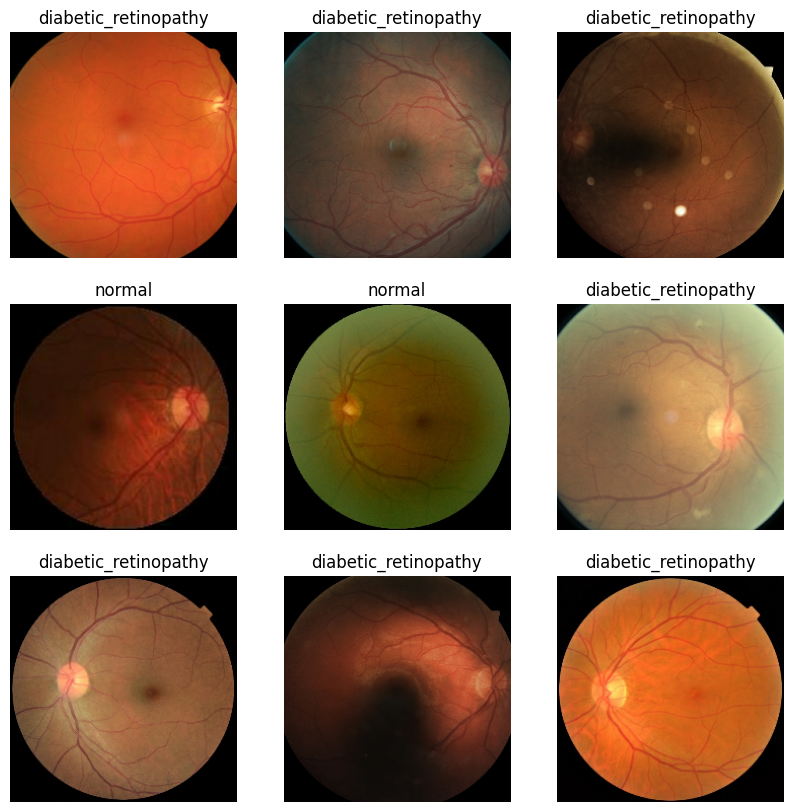

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Preprocessing data

In [7]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
# sns.heatmap(batch[0][1][:,:,1])

In [8]:
sample = data.as_numpy_iterator().next()

In [9]:
print("Minimum value of the scaled data:", sample[0].min())
print("Maximum value of the scaled data:", sample[0].max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


In [10]:
print("There are", len(data), "batches in our data")

There are 35 batches in our data


Splitting the dataset

In [11]:
train_size = int(len(data)*0.70)+1
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)
print("Train Size:", train_size)
print("Validation Size:", val_size)
print("Test Size:", test_size)


Train Size: 25
Validation Size: 7
Test Size: 3


In [12]:
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

Data Augmentation

In [ ]:
# data_augmentation = Sequential([
#     layers.RandomFlip("horizontal_and_vertical", input_shape=(224,224,3)),
#     layers.RandomZoom(0.1),
#     layers.RandomContrast(0.1),
#     layers.RandomRotation(0.2),
# ])

# image = batch[0]


# plt.figure(figsize=(10, 10))
# for i in range(9):
#     augmented_image = data_augmentation(image)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_image[0])
#     plt.axis("off")

Preparing the dataset

In [13]:
test_iter = test.as_numpy_iterator()
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
  try:
    batch = test_iter.next()
    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
  except:
    break

In [14]:
y_true = test_set['labels']

CNN Model

In [ ]:
model = Sequential([
    Conv2D(64, (3,3),  activation="relu", input_shape=(224,224,3)),
    Conv2D(64, (3,3),  activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # Dropout(0.3),
    
    Conv2D(128, (3,3),  activation="relu"),
    Conv2D(128, (3,3),  activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # Dropout(0.3),

    Conv2D(256, (3,3),  activation="relu"),
    Conv2D(256, (3,3),  activation="relu"),
    Conv2D(256, (3,3),  activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # Dropout(0.3),
    
    Conv2D(512, (3,3),  activation="relu"),
    Conv2D(512, (3,3),  activation="relu"),
    Conv2D(512, (3,3),  activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # Dropout(0.3),

    Conv2D(512, (3,3),  activation="relu"),
    Conv2D(512, (3,3),  activation="relu"),
    Conv2D(512, (3,3),  activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # Dropout(0.3),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(4, activation="softmax")
])

DenseNET Model

In [15]:
base_model = tf.keras.applications.densenet.DenseNet121(include_top=True,
                                            input_shape=(224,224)+(3,),
                                            weights= 'imagenet')
model = Sequential()
# model.add(data_augmentation)
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(4, activation='softmax'))

model.layers[0].trainable = False


33188688/33188688 [==============================] - 1s 0us/step


VGG Model

In [ ]:
# base_model = tf.keras.applications.vgg16.VGG16(include_top=True,
#                                             input_shape=(224,224)+(3,),
#                                             weights= 'imagenet')
# model = Sequential()
# # model.add(data_augmentation)
# model.add(base_model)
# model.add(layers.Flatten())
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(4, activation='softmax'))

Resnet

In [ ]:
base_model = tf.keras.applications.resnet.ResNet50(include_top=True,
                                            input_shape=(224,224)+(3,),
                                            weights= 'imagenet')
model = Sequential()
# model.add(data_augmentation)
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(4, activation='softmax'))

model.layers[0].trainable = False


102967424/102967424 [==============================] - 4s 0us/step


In [16]:
model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1000)              8062504   
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4)                 4004      
                                                                 
Total params: 8,070,508
Trainable params: 6,004
Non-trainable params: 8,064,504
__________________________________________

In [18]:
history = model.fit(
    train,
    validation_data=val,
    epochs = 100,
    # callbacks = EarlyStopping(monitor='loss', patience=5)
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


25/25 [==============================] - 29s 446ms/step - loss: 1.1147 - accuracy: 0.5119 - val_loss: 0.8365 - val_accuracy: 0.5246
Epoch 2/100
25/25 [==============================] - 9s 346ms/step - loss: 0.6962 - accuracy: 0.6812 - val_loss: 0.7016 - val_accuracy: 0.6741
Epoch 3/100
25/25 [==============================] - 10s 350ms/step - loss: 0.6183 - accuracy: 0.7212 - val_loss: 0.6922 - val_accuracy: 0.5089
Epoch 4/100
25/25 [==============================] - 10s 356ms/step - loss: 0.5852 - accuracy: 0.7425 - val_loss: 0.6802 - val_accuracy: 0.5558
Epoch 5/100
25/25 [==============================] - 10s 362ms/step - loss: 0.5660 - accuracy: 0.7412 - val_loss: 0.6774 - val_accuracy: 0.5022
Epoch 6/100
25/25 [==============================] - 9s 351ms/step - loss: 0.5534 - accuracy: 0.7412 - val_loss: 0.6785 - val_accuracy: 0.5134
Epoch 7/100
25/25 [==============================] - 9s 346ms/step - loss: 0.5446 - accuracy: 0.7500 - val_loss: 0.6638 - val_accuracy: 0.6830
Epoch 8

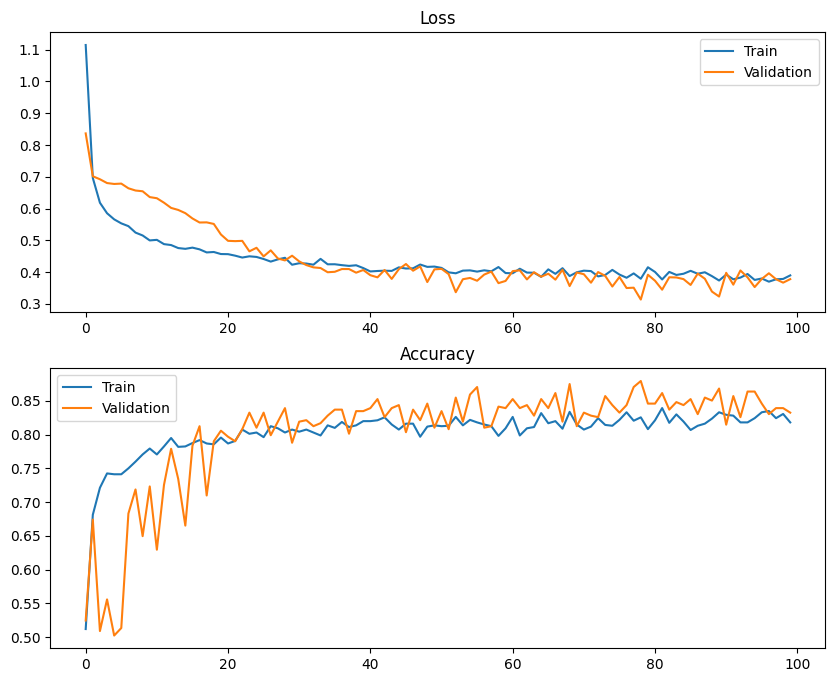

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(history.history["loss"], label="Train")
ax[0].plot(history.history["val_loss"], label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="Train")
ax[1].plot(history.history["val_accuracy"], label="Validation")
ax[1].title.set_text("Accuracy")
ax[1].legend()

plt.show()


In [20]:
y_true

array([0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.])

In [21]:

y_pred = np.argmax(model.predict(test_set['images']), 1)

5/5 [==============================] - 5s 344ms/step


In [22]:
y_pred

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1])

In [23]:
#y_pred_prob = np.argmax(model.predict_proba(test_set['images']), 1)

def predict_prob(number):
  return [number[0],1-number[0]]

y_prob = np.array(list(map(predict_prob, model.predict(test_set['images']))))
y_prob = y_prob[::,1]
y_prob

5/5 [==============================] - 0s 85ms/step


array([8.24311376e-02, 1.90403938e-01, 8.31356108e-01, 8.52876857e-01,
       5.74509740e-01, 7.32929260e-01, 7.97914192e-01, 3.34158540e-02,
       4.71535504e-01, 5.31482577e-01, 9.37822174e-01, 4.56839859e-01,
       9.54338547e-01, 4.87354994e-02, 7.21150160e-01, 1.67958736e-02,
       3.55076790e-03, 4.91100550e-03, 1.75013602e-01, 2.30912566e-02,
       7.71790415e-01, 5.82900852e-01, 4.51409638e-01, 7.57627457e-01,
       4.68446791e-01, 6.25795841e-01, 4.15636539e-01, 2.18153000e-05,
       3.86657715e-01, 9.03880447e-01, 7.02938616e-01, 1.66177750e-04,
       9.40080535e-01, 1.07288361e-06, 1.20561838e-01, 6.43483818e-01,
       8.45906943e-01, 2.03940392e-01, 2.88699985e-01, 8.60068381e-01,
       9.42880925e-01, 6.39114052e-01, 9.55191065e-01, 1.65356994e-02,
       4.95910645e-05, 3.28245401e-01, 6.47870213e-01, 8.67109627e-01,
       8.67025271e-01, 2.37286806e-01, 9.44857825e-01, 8.13526362e-01,
       4.42287922e-02, 3.31530213e-01, 5.96046448e-06, 3.23176384e-04,
      

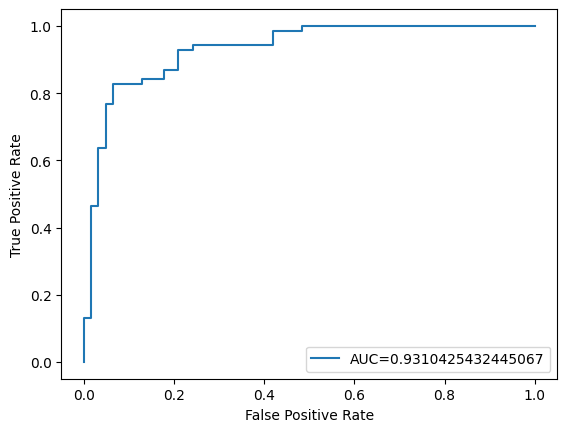

In [24]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_true,  y_prob)
auc = metrics.roc_auc_score(y_true,  y_prob)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()



In [ ]:
pip install sklearn.metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)
ERROR: No matching distribution found for sklearn.metrics


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

ImportError: ignored

In [ ]:
print(classification_report(y_true, y_pred, target_names = class_names))

                      precision    recall  f1-score   support

            cataract       0.82      0.89      0.85        92
diabetic_retinopathy       0.86      0.79      0.83        96
            glaucoma       0.67      0.72      0.69        92
              normal       0.70      0.65      0.67        97

            accuracy                           0.76       377
           macro avg       0.76      0.76      0.76       377
        weighted avg       0.76      0.76      0.76       377



Text(0.5, 1.0, 'Confusion Matrix')

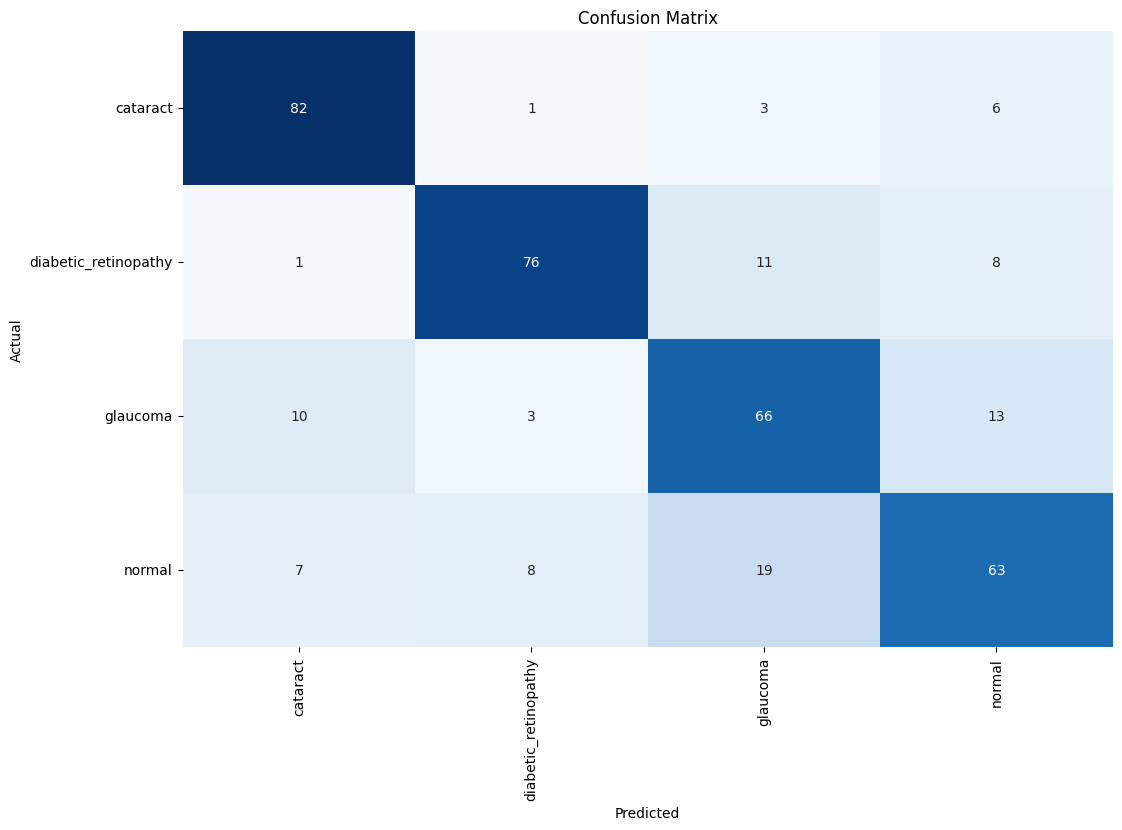

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(4)+.5, class_names, rotation=90)
plt.yticks(np.arange(4)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [ ]:
sensitivity = np.diag(cm)/np.sum(cm,axis=1)
specificity = []
for i in range(cm.shape[0]):
  tn = np.delete(cm, i ,axis=0)[:,np.delete(np.arange(cm.shape[0]),i)]
  fp = np.delete(cm[i:],i)
  specificity.append(np.sum(tn)/ (np.sum(tn)+np.sum(fp)))

In [ ]:
overall_sensitivity = np.mean(sensitivity)
overall_specificity = np.mean(specificity)

In [ ]:
print(f'Overall Sensitivity: {overall_sensitivity}')
print(f'Overall Specficity: {overall_specificity}')

Overall Sensitivity: 0.7624617137307634
Overall Specficity: 0.6478458938232443


# First Updation

Found 2112 images belonging to 2 classes.
Found 2112 images belonging to 2 classes.
58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/100
33/33 [==============================] - 80s 2s/step - loss: 1.4533 - accuracy: 0.4285 - val_loss: 0.8995 - val_accuracy: 0.7079
Epoch 2/100
33/33 [==============================] - 60s 2s/step - loss: 0.8543 - accuracy: 0.6761 - val_loss: 0.6012 - val_accuracy: 0.9200
Epoch 3/100
33/33 [==============================] - 60s 2s/step - loss: 0.6345 - accuracy: 0.7723 - val_loss: 0.5588 - val_accuracy: 0.9200
Epoch 4/100
33/33 [==============================] - 59s 2s/step - loss: 0.5028 - accuracy: 0.8499 - val_loss: 0.4725 - val_accuracy: 0.9342
Epoch 5/100
33/33 [==============================] - 59s 2s/step - loss: 0.4680 - accuracy: 0.8594 - val_loss: 0.4178 - val_accuracy: 0.9366
Epoch 6/100
33/33 [==============================] - 60s 2s/step - loss: 0.4250 - accuracy: 0.8849 - val_loss: 0.3881 - val_accuracy: 0.9280
Epoch

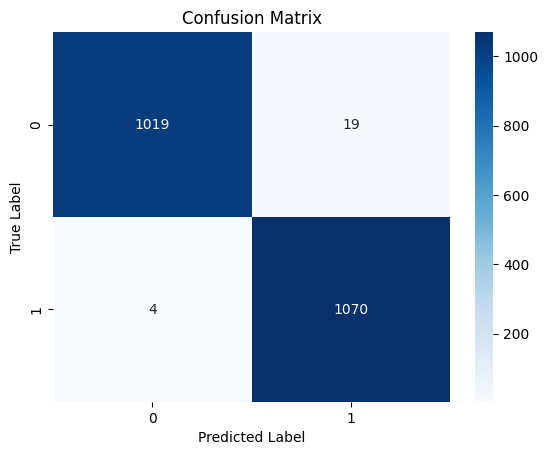

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1038
           1       0.98      1.00      0.99      1074

    accuracy                           0.99      2112
   macro avg       0.99      0.99      0.99      2112
weighted avg       0.99      0.99      0.99      2112



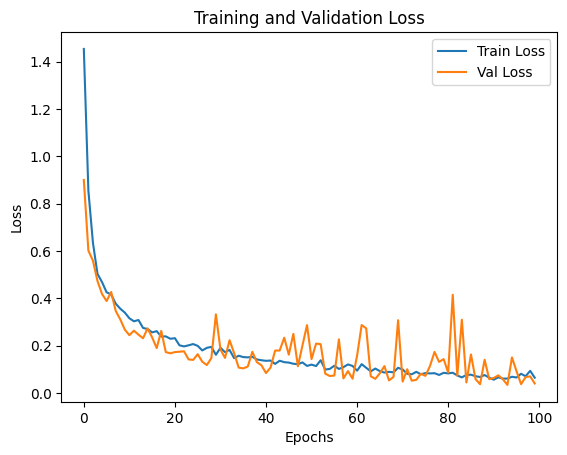

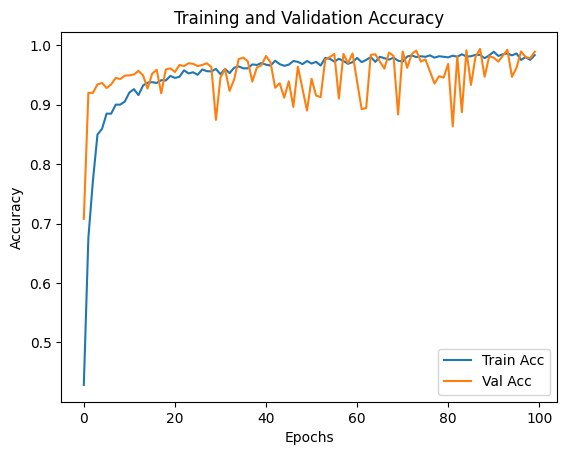

Overall Accuracy: 0.9891098484848485
Class: 0
Sensitivity: 0.9816955684007708
Specificity: 0.9962756052141527
Recall: 0.9816955684007708
Precision: 0.9960899315738025
F1-score: 0.9888403687530326
Class: 1
Sensitivity: 0.9962756052141527
Specificity: 0.9816955684007708
Recall: 0.9962756052141527
Precision: 0.9825528007346189
F1-score: 0.9893666204345817


IndexError: ignored

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Generating dataset from directory
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/shagundeep/dataset/Normal_Cataract/',
    target_size=(224,224),
    batch_size=64,
    class_mode='sparse',
    shuffle=True,
    seed=2022
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/shagundeep/dataset/Normal_Cataract/',
    target_size=(224,224),
    batch_size=64,
    class_mode='sparse',
    shuffle=False
)

# Using VGG16 as the base model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

# Unfreezing some of the layers in the base model for fine-tuning
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Adding custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compiling the model with lower learning rate for fine-tuning
opt = Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    validation_data=val_generator,
                    validation_steps=val_generator.n//val_generator.batch_size,
                    epochs=100,
                    # callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

# Evaluating the model on the validation set
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print('Validation accuracy:', val_acc)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predicting the classes of validation set
y_pred = np.argmax(model.predict(val_generator), axis=-1)

# Extracting the true classes of validation set
y_true = val_generator.classes

# Calculating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculating the classification report
cr = classification_report(y_true, y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Printing the classification report
print('Classification Report:\n', cr)

# Plotting the loss and accuracy curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculating and printing the overall accuracy
overall_acc = np.sum(np.diag(cm))/np.sum(cm)
print('Overall Accuracy:', overall_acc)

# Calculating and printing the sensitivity, specificity, recall, precision, and F1-score per class
num_classes = 2
sensitivity = np.zeros(num_classes)
specificity = np.zeros(num_classes)
recall = np.zeros(num_classes)
precision = np.zeros(num_classes)
f1score = np.zeros(num_classes)

for i in range(num_classes):
    true_positive = cm[i,i]
    false_positive = np.sum(cm[:,i]) - true_positive
    false_negative = np.sum(cm[i,:]) - true_positive
    true_negative = np.sum(cm) - true_positive - false_positive - false_negative
    
    sensitivity[i] = true_positive / (true_positive + false_negative)
    specificity[i] = true_negative / (true_negative + false_positive)
    recall[i] = sensitivity[i]
    precision[i] = true_positive / (true_positive + false_positive)
    f1score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

    print('Class:', i)
    print('Sensitivity:', sensitivity[i])
    print('Specificity:', specificity[i])
    print('Recall:', recall[i])
    print('Precision:', precision[i])
    print('F1-score:', f1score[i])


In [ ]:
# Calculating and printing the sensitivity, specificity, recall, precision, and F1-score per class
num_classes = 2
sensitivity = np.zeros(num_classes)
specificity = np.zeros(num_classes)
recall = np.zeros(num_classes)
precision = np.zeros(num_classes)
f1score = np.zeros(num_classes)

for i in range(num_classes):
    true_positive = cm[i,i]
    false_positive = np.sum(cm[:,i]) - true_positive
    false_negative = np.sum(cm[i,:]) - true_positive
    true_negative = np.sum(cm) - true_positive - false_positive - false_negative
    
    sensitivity[i] = true_positive / (true_positive + false_negative)
    specificity[i] = true_negative / (true_negative + false_positive)
    recall[i] = sensitivity[i]
    precision[i] = true_positive / (true_positive + false_positive)
    f1score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

    print('Class:', i)
    print('Sensitivity:', sensitivity[i])
    print('Specificity:', specificity[i])
    print('Recall:', recall[i])
    print('Precision:', precision[i])
    print('F1-score:', f1score[i])


Class: 0
Sensitivity: 0.9816955684007708
Specificity: 0.9962756052141527
Recall: 0.9816955684007708
Precision: 0.9960899315738025
F1-score: 0.9888403687530326
Class: 1
Sensitivity: 0.9962756052141527
Specificity: 0.9816955684007708
Recall: 0.9962756052141527
Precision: 0.9825528007346189
F1-score: 0.9893666204345817


In [ ]:
y_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:

y_pred = np.argmax(model.predict(test_set['images']), 1)

6/6 [==============================] - 5s 95ms/step


In [ ]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
#y_pred_prob = np.argmax(model.predict_proba(test_set['images']), 1)

def predict_prob(number):
  return [number[0],1-number[0]]

y_prob = np.array(list(map(predict_prob, model.predict(test_set['images']))))
y_prob = y_prob[::,1]
y_prob

6/6 [==============================] - 1s 125ms/step


array([0.02592289, 0.99999938, 0.99999602, 0.00695425, 0.9999997 ,
       0.98001628, 0.99999851, 0.02157533, 0.05643308, 0.9999993 ,
       0.99999762, 0.99999781, 0.00962323, 0.01321173, 0.9999935 ,
       0.99999998, 0.9999997 , 0.11477911, 0.99999988, 0.00548792,
       0.9999727 , 0.00897527, 0.00536942, 0.30353832, 0.06176335,
       0.9999987 , 0.99999667, 0.01165193, 0.99999633, 0.00808752,
       0.01592308, 0.99999992, 0.01628602, 0.99999999, 0.99706314,
       0.99999995, 0.02611208, 0.02136528, 0.01072812, 0.99982759,
       0.99999936, 0.00947136, 0.99999718, 0.01373583, 0.99992874,
       0.03139585, 0.99999627, 1.        , 0.99999786, 0.01935226,
       0.99989698, 0.01206934, 0.99999275, 0.11606234, 0.01480645,
       0.01252025, 0.02232647, 0.0096131 , 0.87977638, 0.99999444,
       0.99999993, 0.01109493, 0.99999305, 0.00632584, 0.01602298,
       0.99999996, 0.99999613, 0.00963479, 0.04226142, 0.00823033,
       0.9999983 , 0.99999959, 0.04110795, 0.01352078, 0.99999

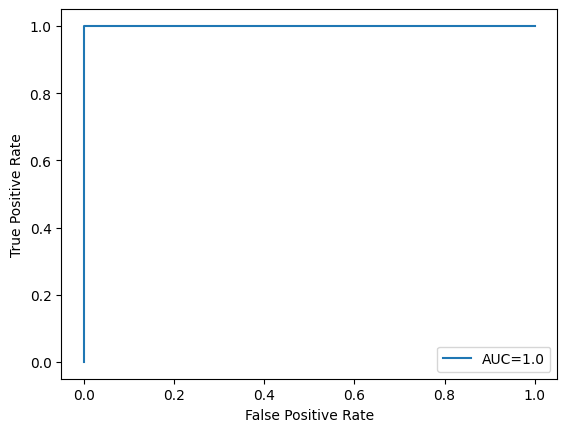

In [ ]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_true,  y_prob)
auc = metrics.roc_auc_score(y_true,  y_prob)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()



# GridSearchCV

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    directory='/content/sample_data/dataset',
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical', # Modify class_mode to 'categorical'
    shuffle=True,
    seed=2022
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    directory='/content/sample_data/dataset',
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical', # Modify class_mode to 'categorical'
    shuffle=False
)


Found 4217 images belonging to 4 classes.
Found 4217 images belonging to 4 classes.


# Ensemble Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Define the input shape for the models
input_shape = (224, 224, 3)

# Create the first base model
base_model1 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
x = GlobalAveragePooling2D()(base_model1.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions1 = Dense(4, activation='softmax')(x)
model1 = Model(inputs=base_model1.input, outputs=predictions1)

# Create the second base model
base_model2 = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
x = GlobalAveragePooling2D()(base_model2.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions2 = Dense(4, activation='softmax')(x)
model2 = Model(inputs=base_model2.input, outputs=predictions2)

# Create an ensemble model that averages the predictions from the base models
ensemble_inputs = Input(shape=input_shape)
model1_predictions = model1(ensemble_inputs)
model2_predictions = model2(ensemble_inputs)
ensemble_predictions = tf.keras.layers.average([model1_predictions, model2_predictions])
ensemble_model = Model(inputs=ensemble_inputs, outputs=ensemble_predictions)

# Compile the ensemble model
optimizer = Adam(lr=0.001)
ensemble_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ensemble model
history = ensemble_model.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    validation_data=val_generator,
                    validation_steps=val_generator.n//val_generator.batch_size,
                    epochs=100)

# Evaluate the ensemble model
test_loss, test_acc = ensemble_model.evaluate(test)
print('Test accuracy:', test_acc)


Epoch 1/100
65/65 [==============================] - 240s 3s/step - loss: 1.1517 - accuracy: 0.2959 - val_loss: 8.2759 - val_accuracy: 0.2639
Epoch 2/100
65/65 [==============================] - 195s 3s/step - loss: 0.9519 - accuracy: 0.2930 - val_loss: 8.4983 - val_accuracy: 0.2495
Epoch 3/100
65/65 [==============================] - 163s 3s/step - loss: 0.9148 - accuracy: 0.2998 - val_loss: 8.4983 - val_accuracy: 0.2231
Epoch 4/100
65/65 [==============================] - 198s 3s/step - loss: 0.9524 - accuracy: 0.2791 - val_loss: 6.4679 - val_accuracy: 0.2445
Epoch 5/100
65/65 [==============================] - 196s 3s/step - loss: 0.8949 - accuracy: 0.2805 - val_loss: 8.0178 - val_accuracy: 0.2445
Epoch 6/100
65/65 [==============================] - 196s 3s/step - loss: 0.8083 - accuracy: 0.2810 - val_loss: 4.3200 - val_accuracy: 0.2445
Epoch 7/100
65/65 [==============================] - 196s 3s/step - loss: 0.7638 - accuracy: 0.2863 - val_loss: 3.1011 - val_accuracy: 0.2445
Epoch 

KeyboardInterrupt: ignored

# RL

In [ ]:
import gym

class DiagnosticEnv(gym.Env):
    def __init__(self, model, data):
        self.model = model
        self.data = data
        self.action_space = gym.spaces.Discrete(4)  # 4 possible diagnoses
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(224, 224, 3))  # image input
        self.current_step = 0
        self.total_steps = len(data)

    def reset(self):
        self.current_step = 0
        return self.data[self.current_step]

    def step(self, action):
        observation = self.data[self.current_step]
        diagnosis = self.model.predict(observation)[0]
        reward = 0
        if diagnosis == action:
            reward = 1  # positive reward for correct diagnosis
        else:
            reward = -1  # negative reward for incorrect diagnosis
        self.current_step += 1
        done = self.current_step == self.total_steps
        return observation, reward, done, {}

import tensorflow as tf
from stable_baselines import PPO2
from stable_baselines.common.policies import MlpPolicy

policy_kwargs = dict(net_arch=[dict(pi=[128, 128], vf=[128, 128])])
model = PPO2(MlpPolicy, env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(total_timesteps=10000)

diagnoses = []
for observation in data:
    action, _ = model.predict(observation)
    diagnoses.append(action)


In [ ]:
# Define the evaluation function
def evaluate(node):
    # Evaluate the score of the node based on the diagnostic model
    # Return a probability distribution or confidence score

# Define the minimax search function with alpha-beta pruning
def alphabeta(node, depth, alpha, beta, maximizing_player):
    if depth == 0 or node.is_terminal():
        # Evaluate the score of the leaf node
        return evaluate(node)
    
    if maximizing_player:
        # Maximize the score for the current player
        best_score = -np.inf
        for child in node.children():
            score = alphabeta(child, depth-1, alpha, beta, False)
            best_score = max(best_score, score)
            alpha = max(alpha, best_score)
            if beta <= alpha:
                break
        return best_score
    else:
        # Minimize the score for the opponent
        best_score = np.inf
        for child in node.children():
            score = alphabeta(child, depth-1, alpha, beta, True)
            best_score = min(best_score, score)
            beta = min(beta, best_score)
            if beta <= alpha:
                break
        return best_score

# Call the minimax search function with alpha-beta pruning on the root node
best_diagnosis = None
best_score = -np.inf
for child in root.children():
    score = alphabeta(child, depth=3, alpha=-np.inf, beta=np.inf, maximizing_player=False)
    if score > best_score:
        best_score = score
        best_diagnosis = child.diagnosis

print("Best diagnosis:", best_diagnosis)
print("Score:", best_score)


# Grid Search & Ensemble Learning

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

# Define the base models
model1 = KNeighborsClassifier()
model2 = SVC()
model3 = DecisionTreeClassifier()

# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('knn', model1), ('svm', model2), ('dt', model3)], voting='hard')

# Define the parameter grid for each individual model
param_grid_model1 = {'n_neighbors': [3, 5, 7, 9]}
param_grid_model2 = {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf']}
param_grid_model3 = {'max_depth': [3, 5, 7, 9]}

# Define the grid search for each individual model
grid_search_model1 = GridSearchCV(model1, param_grid_model1, cv=5)
grid_search_model2 = GridSearchCV(model2, param_grid_model2, cv=5)
grid_search_model3 = GridSearchCV(model3, param_grid_model3, cv=5)

# Fit the grid search for each individual model
grid_search_model1.fit(X_train, y_train)
grid_search_model2.fit(X_train, y_train)
grid_search_model3.fit(X_train, y_train)

# Print the best hyperparameters for each individual model
print("Best hyperparameters for model 1:", grid_search_model1.best_params_)
print("Best hyperparameters for model 2:", grid_search_model2.best_params_)
print("Best hyperparameters for model 3:", grid_search_model3.best_params_)

# Set the best hyperparameters for each individual model
model1.set_params(**grid_search_model1.best_params_)
model2.set_params(**grid_search_model2.best_params_)
model3.set_params(**grid_search_model3.best_params_)

# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate the ensemble model
ensemble_score = ensemble_model.score(X_test, y_test)
print("Ensemble model accuracy:", ensemble_score)
